# 졸음운전 방지 프로젝트

- 목적: 졸음운전을 방지하여 안전운전에 도움이 되도록 함
- 방법: 일정시간 이상 눈이 감겨 있으면 경고를 함
- Dataset: https://www.kaggle.com/datasets/tauilabdelilah/mrl-eye-dataset
- 안구트래킹: cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
- Image 분류 모델
  - Pre-Trained 모델: Keras의 MobileNet
  - Activation 함수: Sigmoid (이진분류)

In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

### Train 이미지 출력

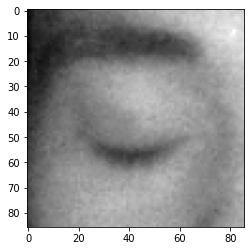

In [2]:
img_array = cv2.imread("data/train/close eyes/s0001_00001_0_0_0_0_0_01.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img_array, cmap="gray")

In [3]:
img_array.shape

(86, 86)

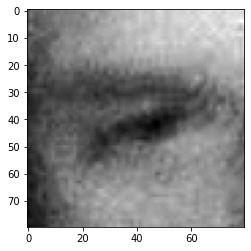

In [4]:
img_array = cv2.imread("data/train/open eyes/s0009_00366_0_0_1_0_0_01.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img_array, cmap="gray")

In [5]:
img_array.shape

(80, 80)

### 이미지 Resize 테스트

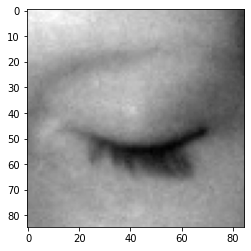

In [6]:
trainDirectory = "data/train"
Classes = ["close eyes", "open eyes"]
for category in Classes:
    path = os.path.join(trainDirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

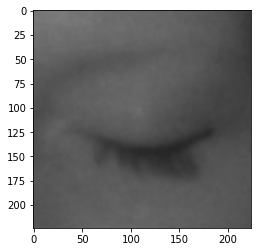

In [7]:
img_size = 224

new_array = cv2.resize(backtorgb, (img_size, img_size))
plt.imshow(new_array, cmap="gray")
plt.show()

### train data set 생성

In [8]:
train_data = []

def create_train_data():
    for category in Classes:
        image_count = 0
        path = os.path.join(trainDirectory, category)
        class_num = Classes.index(category)
            
        for img in os.listdir(path):
            if image_count >= 3000:
                break
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
                new_array = cv2.resize(backtorgb, (img_size, img_size))
                train_data.append([new_array, class_num])
                image_count += 1
            except Exception as e:
                pass

In [9]:
create_train_data()

In [10]:
print(len(train_data))

6000


In [11]:
import random

random.shuffle(train_data)

In [12]:
X = []
y = []

for features, label in train_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, img_size, img_size, 3)

In [13]:
X.shape

(6000, 224, 224, 3)

In [14]:
X = X/255.0

In [15]:
Y = np.array(y)

### Pre-Trained Model 불러오기

In [16]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model

In [17]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(include_top=False, input_shape=(224,224,3))

Metal device set to: AMD Radeon Pro 5300M


2022-09-29 18:14:18.556027: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-29 18:14:18.556274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [19]:
for layer in mobilenet.layers:
    layer.trainable = False

In [20]:
model = mobilenet.output
model = Flatten()(model)
model = Dense(64, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(1,activation= 'sigmoid')(model)

model = Model(inputs=mobilenet.input, outputs= model)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

In [22]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [23]:
X.shape, Y.shape

((6000, 224, 224, 3), (6000,))

### Callback: Model CheckPoint, Early Stopping, Learning Rate Change

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [25]:
checkpoint = ModelCheckpoint(r'models/model.h5',
                            monitor='val_loss',save_best_only=True,verbose=3)

earlystop = EarlyStopping(monitor = 'val_loss', patience=7, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

callbacks=[checkpoint,earlystop,learning_rate]

In [26]:
history = model.fit(X, Y, callbacks=callbacks, epochs = 50, validation_split = 0.1, batch_size=16)

Epoch 1/50


2022-09-29 18:14:39.617824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - ETA: 0s - loss: 0.2825 - accuracy: 0.9256

2022-09-29 18:15:07.091147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.08837, saving model to models/model.h5
338/338 [==============================] - 32s 84ms/step - loss: 0.2825 - accuracy: 0.9256 - val_loss: 0.0884 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 2/50
337/338 [============================>.] - ETA: 0s - loss: 0.1383 - accuracy: 0.9616
Epoch 2: val_loss improved from 0.08837 to 0.05996, saving model to models/model.h5
338/338 [==============================] - 22s 66ms/step - loss: 0.1386 - accuracy: 0.9615 - val_loss: 0.0600 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 3/50
337/338 [============================>.] - ETA: 0s - loss: 0.1107 - accuracy: 0.9674
Epoch 3: val_loss did not improve from 0.05996
338/338 [==============================] - 22s 65ms/step - loss: 0.1106 - accuracy: 0.9674 - val_loss: 0.0625 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 4/50
337/338 [============================>.] - ETA: 0s - loss: 0.0973 - accuracy: 0.9714
Epoch 4: val_loss did not improve from 0.05996
338/338 [======

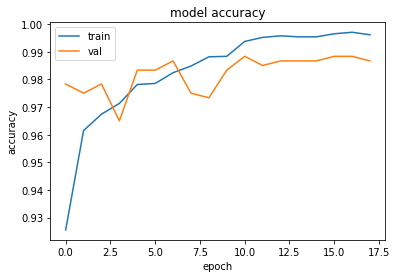

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

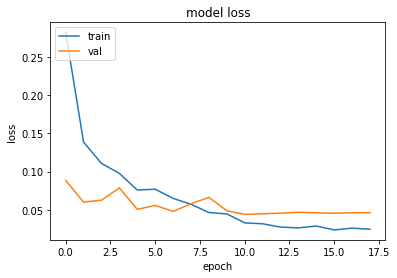

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model Prediction Test

In [29]:
test_data = []
testDirectory = 'data/test'

def create_test_data():
    for category in Classes:
        path = os.path.join(testDirectory, category)
        class_num = Classes.index(category)
            
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
                new_array = cv2.resize(backtorgb, (img_size, img_size))
                test_data.append([new_array, class_num])
                image_count += 1
            except Exception as e:
                pass

In [30]:
create_test_data()

In [31]:
print(len(test_data))

3223


In [32]:
random.shuffle(test_data)

In [33]:
X_test = []
y_test = []

for features, label in test_data:
    X_test.append(features)
    y_test.append(label)
    
X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)

In [34]:
X_test.shape

(3223, 224, 224, 3)

In [35]:
X_test = X_test/255.0

In [36]:
Y_test = np.array(y_test)

In [37]:
loss,accuracy = model.evaluate(X_test,Y_test)

101/101 [==============================] - 9s 86ms/step - loss: 0.3730 - accuracy: 0.9004


### Open / Close 샘플 이미지 Prediction Test

#### Close Eye

In [38]:
img_array = cv2.imread('data/test/close eyes/s0002_00001_0_0_0_0_0_01.png', cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb, (img_size, img_size))

X_input = np.array(new_array).reshape(1, img_size, img_size, 3)
X_input.shape

(1, 224, 224, 3)

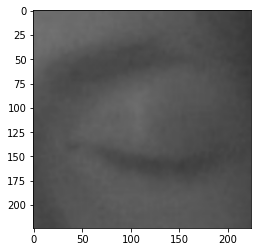

In [39]:
plt.imshow(new_array)

In [40]:
X_input = X_input/255.0

In [41]:
prediction = model.predict(X_input)
prediction

2022-09-29 18:21:58.269128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 870ms/step


array([[8.100436e-05]], dtype=float32)

#### Open Eye

In [42]:
img_array = cv2.imread('data/test/open eyes/s0001_01842_0_0_1_0_0_01.png', cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb, (img_size, img_size))

X_input = np.array(new_array).reshape(1, img_size, img_size, 3)
X_input.shape

(1, 224, 224, 3)

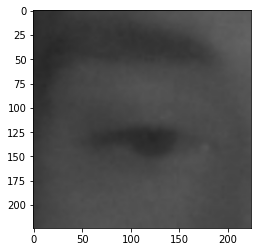

In [43]:
plt.imshow(new_array)

In [44]:
X_input = X_input/255.0

In [45]:
prediction = model.predict(X_input)
prediction

1/1 [==============================] - 0s 49ms/step


array([[0.32571054]], dtype=float32)

### 얼굴 이미지에서 눈을 찾고 Prediction Test

In [46]:
img = cv2.imread("woman.png")

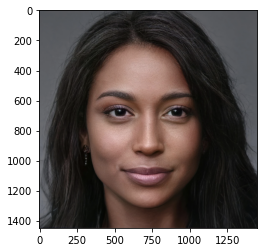

In [47]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [48]:
eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [49]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [50]:
eyes = eyeCascade.detectMultiScale(gray, 1.1, 4)

In [51]:
for(x, y, w, h) in eyes:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

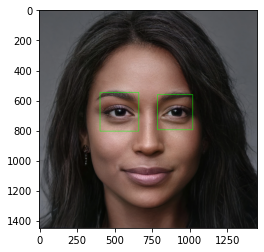

In [52]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [53]:
for x,y,w,h in eyes:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyess = eyeCascade.detectMultiScale(roi_gray)
    if len(eyess) == 0:
        print("eyes are not detected")
    else:
        for (ex,ey,ew,eh) in eyess:
            eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]

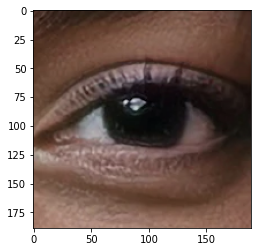

In [54]:
plt.imshow(cv2.cvtColor(eyes_roi, cv2.COLOR_BGR2RGB))

In [55]:
eyes_roi.shape

(189, 189, 3)

In [56]:
final_image = cv2.resize(eyes_roi, (224, 224))
final_image = np.expand_dims(final_image, axis=0)
final_image = final_image/255.0

In [57]:
final_image.shape

(1, 224, 224, 3)

In [58]:
prediction = model.predict(final_image)

1/1 [==============================] - 0s 53ms/step


In [59]:
prediction

array([[1.]], dtype=float32)